# Building a pitch classifier using 2019 MLB pitch data

This notebook assignment has been repurposed to read the 2019_pitches.csv dataset from https://www.kaggle.com/pschale/mlb-pitch-data-20152018?select=pitches.csv


This is the spin axis polar coordinate system used by the Kaggle dataset:


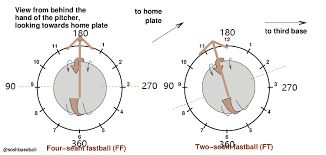

### Import required modules and load data file

In [83]:
%matplotlib notebook
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA #https://www.youtube.com/watch?v=Lsue2gEM9D0
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

path = r"C:\Users\pjrac\OneDrive\Documents\baseball_pitch_classifier"

pitches = pd.read_csv(path+r'\\data\\pitches.csv')
pitch_type_dictionary = pd.read_csv(path+r'\\data\\pitch_type_dictionary.csv')
atbats = pd.read_csv(path+r"\\data\\atbats.csv")

# Data exploration

First, let's take a look at the columns and look at the distribution of pitches

In [50]:
print(pitches.columns)

#Distribution of pitches
pitches['pitch_type'].value_counts()

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')


FF    1014877
SL     450578
FT     337983
CH     292789
SI     242504
CU     234391
FC     149756
KC      66484
FS      43705
KN      11260
IN       6197
EP        815
FO        810
PO        628
SC        113
UN         57
FA          9
AB          9
Name: pitch_type, dtype: int64

Let's select high-usage pitches only for our model and merge with a pitch name dataset for readability

In [84]:
pitch_list = ['FF', 'FT', 'CH', 'SI', 'SL', 'CU', 'FC', 'KC']

## Create a coded value field for color mapping later
pitch_type_coded = {'FF':1, 'FT':2, 'CH':3, 'SI':4, 'SL':5, 'CU':6, 'FC':7}
pitches['pitch_type_coded'] = pitches['pitch_type'].map(pitch_type_coded)

pitches = pitches.loc[pitches["pitch_type"].isin(pitch_list)]

## Merge with pitch name
pitches = pitches.merge(pitch_type_dictionary, on='pitch_type', how='left')
display(pitches[['pitch_type', 'pitch_type_coded', 'pitch_name']].head())

pitch_type  pitch_type_coded          pitch_name
0         FF               1.0  Four-seam Fastball
1         FF               1.0  Four-seam Fastball
2         FF               1.0  Four-seam Fastball
3         FF               1.0  Four-seam Fastball
4         CU               6.0           Curveball

Merge atbats.csv and pitches on ab_id and now let's look at the plot with pitcher handedness

In [85]:
pitches = pitches.merge(atbats, on = "ab_id")

display(pitches.head())

px     pz  start_speed  end_speed  spin_rate  spin_dir  break_angle  \
0  0.416  2.963         92.9       84.1   2305.052   159.235        -25.0   
1 -0.191  2.347         92.8       84.1   2689.935   151.402        -40.7   
2 -0.518  3.284         94.1       85.2   2647.972   145.125        -43.7   
3 -0.641  1.221         91.0       84.0   1289.590   169.751         -1.3   
4 -1.821  2.083         75.4       69.6   1374.569   280.671         18.4   

   break_length  break_y      ax  ...  batter_id      event       g_id  \
0           3.2     23.7   7.665  ...     572761  Groundout  201500001   
1           3.4     23.7  12.043  ...     572761  Groundout  201500001   
2           3.7     23.7  14.368  ...     572761  Groundout  201500001   
3           5.0     23.8   2.104  ...     572761  Groundout  201500001   
4          12.0     23.8 -10.280  ...     572761  Groundout  201500001   

   inning  o  p_score  p_throws  pitcher_id  stand   top  
0       1  1        0         L      452657      L  True  
1       1  1        0         L      452657      L  True  
2       1  1        0         L      452657      L  True  
3       1  1        0         L      452657      L  True  
4       1  1        0         L      452657      L  True  

[5 rows x 52 columns]

### Create training and test sets

Let's now define X and y for all future code as well as a subset of the pitches dataset to increase processing time for some of our analyses

In [86]:
def create_x_y(data):

    pitches_subset = pitches.sample(n=200000)

    ## Can this be a list of values and "is not in [list]"
    X = pitches_subset.loc[:, (pitches_subset.columns != 'pitch_name') & (pitches_subset.columns != 'pitch_type') 
              & (pitches_subset.columns != 'pitch_type_coded') & (pitches_subset.columns != 'p_throws')]

    y = np.ravel(np.array(pitches_subset['pitch_type']))
    
    output = {"X":X, "y":y}

    return output

X = create_x_y(pitches)['X']
y = create_x_y(pitches)['y']

### Most influential features

By looking at the column names, I already have a good idea of what features are going to influence pitch type detection. However, there are a number of features in this dataset with names that don't indicate what they represent.

Let's run a decision tree to get feature importance and see how the ones I'm anticipating will be important (spin direction, start speed, etc.) stack up against the unknown features.

In [54]:
def decision_tree(X, y):
    from sklearn.tree import DecisionTreeClassifier
    
    ## Only use numeric-type fields
    ## We're not going to create dummy variable for fields we know are irrelevant (ex. outcome)
    X = X.select_dtypes(['number'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, random_state=0)

    clf = DecisionTreeClassifier(random_state=0, max_depth = 20).fit(X_train, y_train)
    feature_imp = clf.feature_importances_

    
    features = pd.DataFrame({
        "feature_name":X_train.columns, 
        "importance":feature_imp}
                           ).sort_values(by="importance", ascending=False)
    
    display(features)
    
#     evaluation = clf.get_depth()
#     evaluation = clf.get_params()
    print(clf.score(X_train, y_train))
#     return evaluation


decision_tree(X, y)

feature_name  importance
22               z0    0.046280
10               ay    0.045987
15              vx0    0.042172
12           sz_bot    0.041798
37        batter_id    0.041640
13           sz_top    0.040043
19               x0    0.039707
17              vz0    0.037966
27        event_num    0.037448
25            nasty    0.036394
20                y    0.032361
42       pitcher_id    0.030889
1                pz    0.029033
4         spin_rate    0.028996
29            ab_id    0.026807
16              vy0    0.026694
5          spin_dir    0.026051
6       break_angle    0.025885
3         end_speed    0.025665
18                x    0.025185
0                px    0.024791
11               az    0.024492
23            pfx_x    0.022055
24            pfx_z    0.021543
9                ax    0.021450
38             g_id    0.020659
41          p_score    0.019678
2       start_speed    0.019115
7      break_length    0.018132
14  type_confidence    0.017396
28          b_score    0.016710
26             zone    0.012709
33        pitch_num    0.012409
39           inning    0.011868
40                o    0.010098
32             outs    0.009821
31          s_count    0.006963
30          b_count    0.006100
34            on_1b    0.005603
36            on_3b    0.004790
8           break_y    0.003961
35            on_2b    0.002656
21               y0    0.000000

0.40741578947368423


Based off these results, I'm going to include the following features in my classification model based on their importance and my ability to interpret their meaning with the little information that's provided with the dataset. I'm also going to include all of my qualitative pitch type fields and then redefine X

In [90]:
## Create list of fields we're interested in
columns = ['break_length', 'spin_rate', 'start_speed', 'ax', 'break_angle', 'spin_dir', 'end_speed',
          'pitch_type', 'pitch_name', 'pitch_type_coded', 'p_throws']

pitches = pitches[columns]

X = create_x_y(pitches)['X']
y = create_x_y(pitches)['y']

### Descriptive stats

Let's get descriptive stats on our selected features for each pitch type, grouped by the handedness of the pitcher

In [56]:
pitcher_throws = ['L', 'R']

def descriptive_stats(df, handed):
    
    print("Descriptive stats for a {}HP:".format(handed))
    
    ## Filter for pitcher handedness
    df = df.loc[df['p_throws'] == handed]
    
    ## take a random sample to increase processing speeds
    df = df.sample(n = 10000)
    
    ## Get average pitch metrics
    X = df[columns].drop(columns = 'pitch_type_coded')
    pitches_subset = X.set_index("pitch_name")
    pitches_summary = pitches_subset.groupby(['p_throws','pitch_name']).describe().stack(level=0)

    display(pitches_summary[:60])
    return pitches_summary
        
for p in pitcher_throws:
    descriptive_stats(pitches, p)

Descriptive stats for a LHP:


25%          50%  \
p_throws pitch_name                                                  
L        Changeup           ax              10.172500    12.959424   
                            break_angle    -29.500000   -24.900000   
                            break_length     6.900000     7.800000   
                            end_speed       74.700000    76.700000   
                            spin_dir       109.085250   119.553500   
                            spin_rate     1606.995750  1865.996500   
                            start_speed     81.200000    83.400000   
         Curveball          ax              -7.357500    -4.988000   
                            break_angle      4.400000     8.000000   
                            break_length    11.125000    12.600000   
                            end_speed       68.600000    70.900000   
                            spin_dir       289.976500   314.132000   
                            spin_rate      780.078000  1143.532500   
                            start_speed     74.300000    76.800000   
         Cutter             ax              -1.639537     0.392591   
                            break_angle     -3.800000     1.700000   
                            break_length     5.400000     6.100000   
                            end_speed       79.325000    80.800000   
                            spin_dir       162.296250   177.356000   
                            spin_rate      781.129750  1036.639500   
                            start_speed     85.700000    87.400000   
         Four-seam Fastball ax               6.743158    10.219423   
                            break_angle    -36.600000   -28.700000   
                            break_length     3.600000     4.200000   
                            end_speed       82.800000    84.400000   
                            spin_dir       141.046000   149.956000   
                            spin_rate     1974.392750  2238.692000   
                            start_speed     90.400000    92.000000   
         Knuckle curve      ax              -5.028716    -3.389000   
                            break_angle      2.900000     5.500000   
                            break_length    10.150000    11.700000   
                            end_speed       71.850000    73.700000   
                            spin_dir       265.649000   321.477000   
                            spin_rate      535.087000  1003.150000   
                            start_speed     77.850000    79.700000   
         Sinker             ax              13.606000    16.004471   
                            break_angle    -39.400000   -33.900000   
                            break_length     5.100000     6.000000   
                            end_speed       82.100000    83.700000   
                            spin_dir       113.424000   125.137000   
                            spin_rate     1956.862000  2215.079000   
                            start_speed     89.700000    91.200000   
         Slider             ax              -5.271191    -2.211286   
                            break_angle      1.600000     5.700000   
                            break_length     7.300000     8.600000   
                            end_speed       74.700000    77.000000   
                            spin_dir       178.009000   220.826000   
                            spin_rate      429.560000   693.968000   
                            start_speed     80.900000    83.200000   
         Two-seam Fastball  ax              13.561000    16.291000   
                            break_angle    -39.800000   -34.300000   
                            break_length     5.300000     6.000000   
                            end_speed       82.400000    84.000000   
                            spin_dir       115.662500   125.732000   
                            spin_rate     1930.169000  2241.896000   
                            start_speed     89.700000    91.

Descriptive stats for a RHP:


25%          50%  \
p_throws pitch_name                                                  
R        Changeup           ax             -14.336683   -11.829421   
                            break_angle     17.200000    22.100000   
                            break_length     6.700000     7.500000   
                            end_speed       75.800000    78.200000   
                            spin_dir       227.557250   239.960500   
                            spin_rate     1418.598250  1711.707000   
                            start_speed     82.300000    84.700000   
         Curveball          ax               4.065206     6.612310   
                            break_angle    -14.200000   -10.200000   
                            break_length    10.700000    12.300000   
                            end_speed       70.250000    73.200000   
                            spin_dir        33.339000    47.317000   
                            spin_rate      936.306000  1338.136000   
                            start_speed     76.050000    79.000000   
         Cutter             ax              -0.549647     1.832745   
                            break_angle    -11.850000    -6.700000   
                            break_length     4.800000     5.800000   
                            end_speed       80.100000    82.200000   
                            spin_dir       148.537500   169.148000   
                            spin_rate      798.512000  1101.167000   
                            start_speed     86.500000    88.800000   
         Four-seam Fastball ax             -11.977918    -8.650000   
                            break_angle     15.700000    25.300000   
                            break_length     3.300000     3.900000   
                            end_speed       83.800000    85.500000   
                            spin_dir       196.654000   206.039000   
                            spin_rate     1912.137000  2156.478000   
                            start_speed     91.400000    93.200000   
         Knuckle curve      ax               3.820315     6.263000   
                            break_angle    -12.900000    -9.300000   
                            break_length    11.000000    12.000000   
                            end_speed       72.700000    74.500000   
                            spin_dir        27.214000    40.303000   
                            spin_rate     1074.833000  1425.821000   
                            start_speed     78.700000    80.700000   
         Sinker             ax             -18.565257   -16.008448   
                            break_angle     25.800000    31.050000   
                            break_length     5.600000     6.300000   
                            end_speed       82.400000    84.300000   
                            spin_dir       230.438250   240.907000   
                            spin_rate     1811.681000  2059.497000   
                            start_speed     89.700000    91.600000   
         Slider             ax               1.003719     3.472000   
                            break_angle    -12.600000    -8.000000   
                            break_length     6.900000     8.000000   
                            end_speed       76.400000    78.900000   
                            spin_dir        91.476000   131.426000   
                            spin_rate      512.593000   766.652000   
                            start_speed     82.700000    85.100000   
         Two-seam Fastball  ax             -18.276000   -15.867531   
                            break_angle     29.300000    34.500000   
                            break_length     5.100000     5.700000   
                            end_speed       83.500000    85.200000   
                            spin_dir       224.938000   233.055000   
                            spin_rate     1933.506000  2200.564000   
                            start_speed     91.000000    92.

### Plot the spin direction of each pitch ###

In order to build our classifier model, we will need to distinguish between LHP and RHP in the dataset, as their spin and break metrics will not be similar. We can take a look at the data in a cartestian coordinate system and see how LHP v RHP two-seam fastballs for two distinct clusters when plotted by start speed v spin direction. Thankfully, we can join the pitches dataset to the atbats dataset and get the handedness of the pitchers. Otherwise, we could build a linear classifier model based on the spin direction clusters for each pitch and classify the handedness of the pitchers

<IPython.core.display.Javascript object>


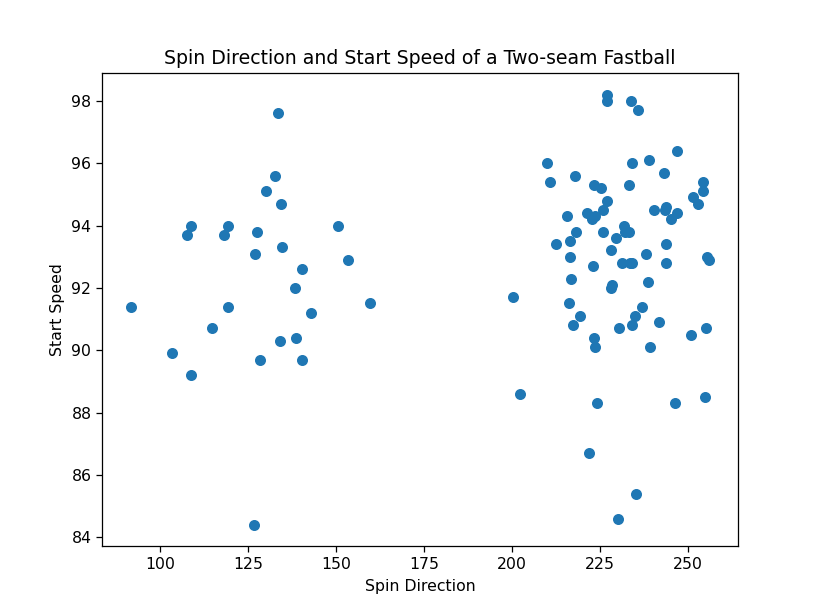

In [57]:
def cartesian_plot(df, pitch_type):
    
    ## Filter for pitch type
    df = df.loc[df['pitch_type'] == pitch_type]

    ## Get pitch type long name
    pitch_name = df.iloc[0]["pitch_name"]    
    
    ## Take random sample from dataset to improve processing speeds
    df = df.sample(n = 100)
    
    ## Read in two variables
    x = np.array(df.start_speed)
    y = np.array(df.spin_dir)
    
    
    ## Create plot
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(y,x)
    
    plt.xlabel("Spin Direction")
    plt.ylabel("Start Speed")
    plt.title("Spin Direction and Start Speed of a {}".format(pitch_name))
    
cartesian_plot(pitches, "FT")

### Plot in polar coordinates ###

To get a true sense of the spin direction of pitches, we plot convert cartesian coordinates into polar coordinates. And this time, we're going to color coordinate based on the handedness of the pitcher

<IPython.core.display.Javascript object>


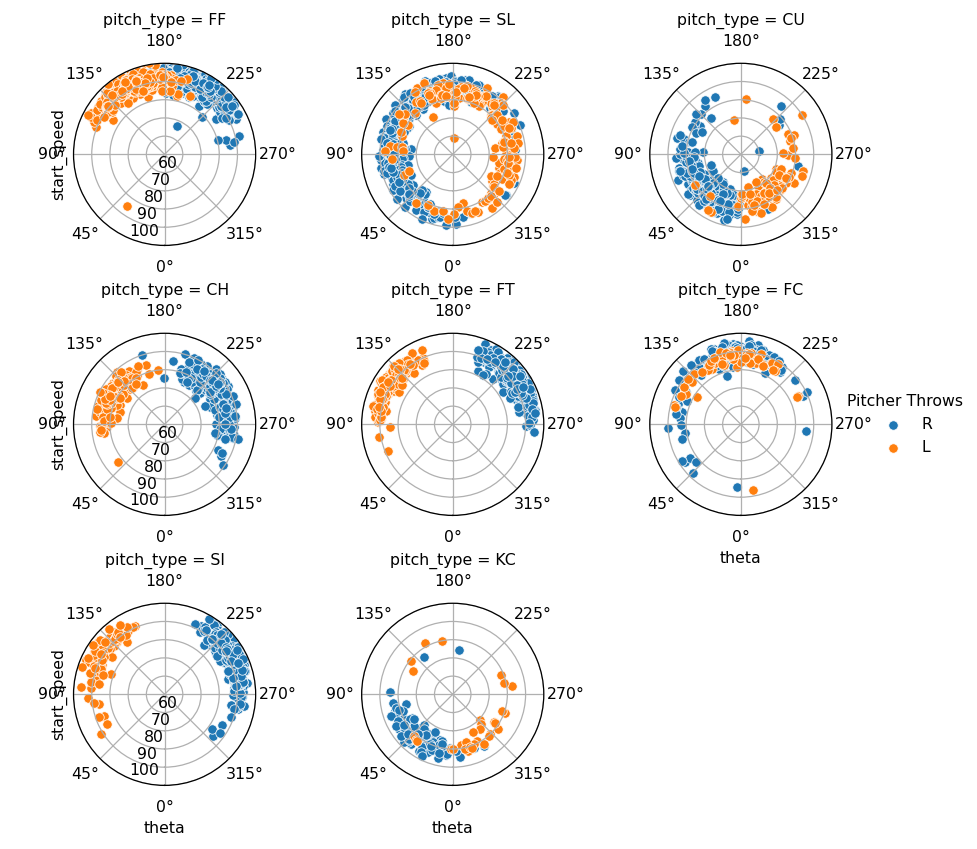

In [58]:
import seaborn as sns

def seaborn_multiplot():
    df = pitches.sample(n = 5000)
  
    df['theta'] = np.deg2rad(df['spin_dir'])
    
    g = sns.FacetGrid(df, col="pitch_type", col_wrap=3, height=2.5, ylim=(50, 100), hue="p_throws",
                 subplot_kws=dict(projection='polar'),sharex=False, sharey=True, despine=False)
    
    g.map(sns.scatterplot, "theta", "start_speed")
    g.add_legend(title="Pitcher Throws")
    
    ## Rotate the polar axis so - is on bottom and it increases clockwise
    for ax in g.axes:
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.deg2rad(-90))
    
#     plt.legend(title='Pitcher Throws', bbox_to_anchor=(1.05, 1), loc='upper left')

seaborn_multiplot()

### Collinearity ###

We need to run some collinearity tests on our features first to improve model performance. I suspect features like start speed and end speed will be highly correlated. We can usee the .corr() method, a scatter matrix, as well as the variance inflation factor (VIF) to identify collinearity

## Can i just run this on the dataframe and not X_train? I should be doing X_train later

break_length  spin_rate  start_speed        ax  break_angle  \
break_length          1.000000  -0.012131    -0.017440  0.004947    -0.004941   
spin_rate            -0.012131   1.000000     0.556006 -0.191412     0.222678   
start_speed          -0.017440   0.556006     1.000000 -0.288059     0.292622   
ax                    0.004947  -0.191412    -0.288059  1.000000    -0.965763   
break_angle          -0.004941   0.222678     0.292622 -0.965763     1.000000   
spin_dir             -0.006718   0.194848     0.289377 -0.727769     0.647928   
end_speed            -0.016214   0.499304     0.987418 -0.279034     0.280249   
pitch_type_coded      0.015333  -0.657529    -0.651898  0.246389    -0.271531   

                  spin_dir  end_speed  pitch_type_coded  
break_length     -0.006718  -0.016214          0.015333  
spin_rate         0.194848   0.499304         -0.657529  
start_speed       0.289377   0.987418         -0.651898  
ax               -0.727769  -0.279034          0.246389  
break_angle       0.647928   0.280249         -0.271531  
spin_dir          1.000000   0.279902         -0.281394  
end_speed         0.279902   1.000000         -0.618825  
pitch_type_coded -0.281394  -0.618825          1.000000

<IPython.core.display.Javascript object>


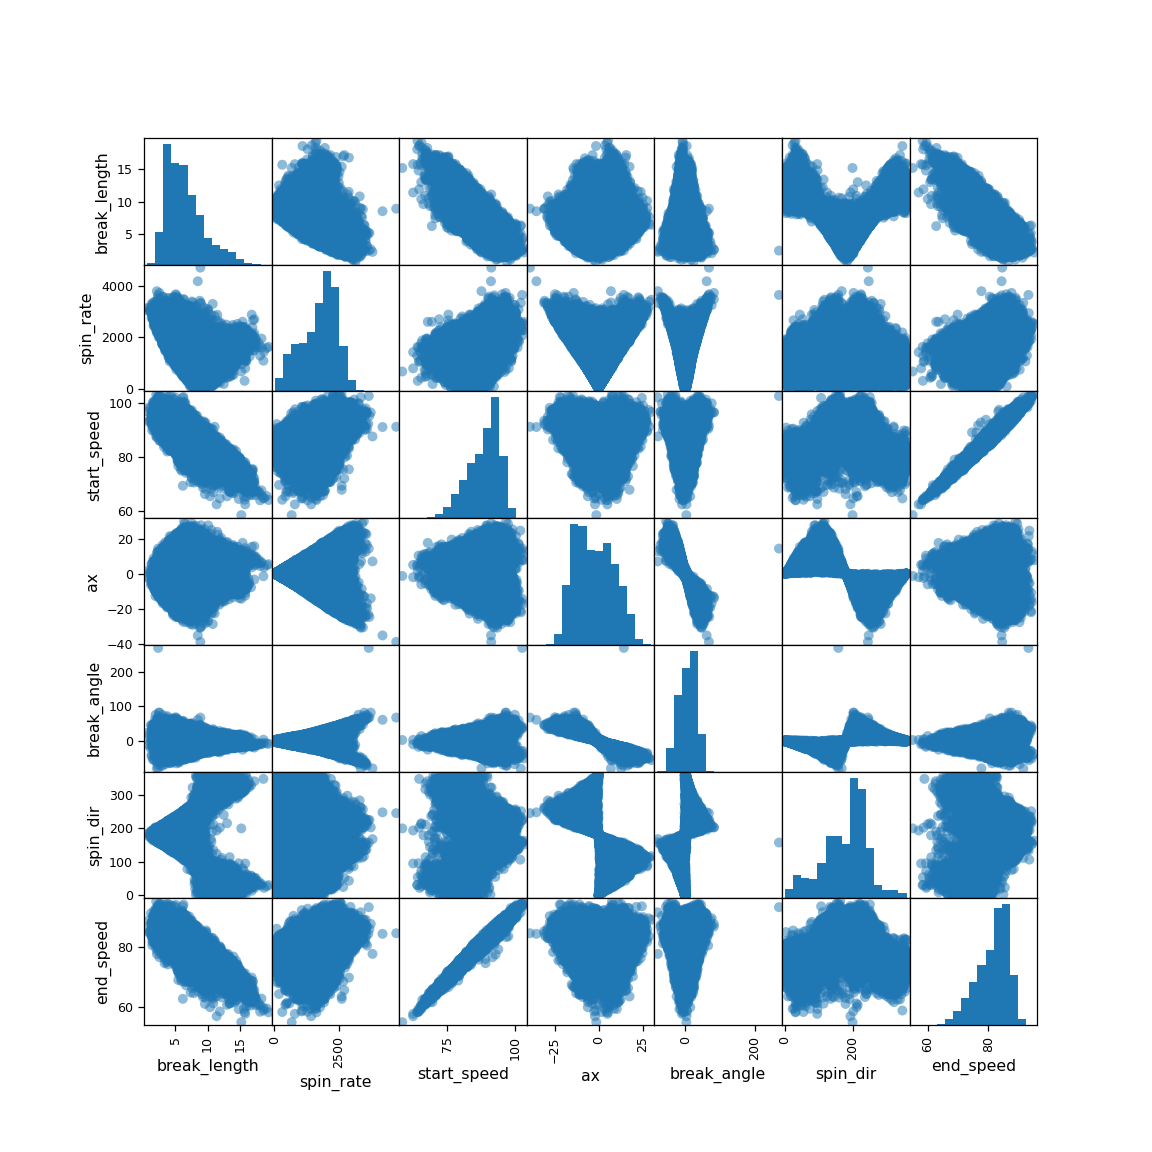

VIF  Tolerance
break_length   3.903058   0.256209
spin_rate      1.729886   0.578073
start_speed   52.801547   0.018939
ax            20.487743   0.048810
break_angle   16.503426   0.060593
spin_dir       2.542757   0.393274
end_speed     46.782510   0.021376

In [91]:
from matplotlib import cm
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=0)

## Correlation dataframe
correlation = pitches.corr()
display(correlation)

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)

## Calculate VIF
def calculate_vif(df, features):    
    vif, tolerance = {}, {}    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2        # calculate VIF
        vif[feature] = 1/(tolerance[feature])    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

calculate_vif(X_train, features=X_train.columns)

There appears to be a high degree of positive correlation between start and end speed, which we expected. Interstingly, there is also a high degree of negative correlation between axis and break angle, as shown in the correlation dataframe and validated by the VIF stats. Let's remove end speed from all variables, since start speed is by default the metric we refer to in baseball vernacular when talking about "pitch speed". Let's also remove break angle in favor of axis, since axis rated higher in our decision tree feature importance output from before.

In [92]:
pitches.drop(columns = ['end_speed', 'break_angle'], inplace=True)
X_train.drop(columns = ['end_speed', 'break_angle'], inplace=True)
X_test.drop(columns = ['end_speed', 'break_angle'], inplace=True)
X.drop(columns = ['end_speed', 'break_angle'], inplace=True)

C:\Users\pjrac\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Creating the model

Create training test split

### Normalize features with feature scaling

Now were ready to start running our model. Let's use feature scaling to clean up our features and improve model performance. We can compare scaled and not scaled feature performance with our k-nearest neighbors model, as well as multiple sizes of k.

Since we're ready to run our model, let's reassign our X and y variable using the full pitches dataset.

In [61]:
def min_max_scale(X):
    
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)

    return scaled_X
    
## Put our scaled features into a dataframe for future use
X_train_minmax = min_max_scale(X_train)
X_test_minmax = min_max_scale(X_test)

### Compare size of k and scaled vs. non-scaled

Running k-size 5
Running k-size 10
Running k-size 15
Running k-size 20
Running k-size 25
Running k-size 30
Running k-size 35
Running k-size 40
Running k-size 45
Running k-size 50
Running k-size 55
Running k-size 60
Running k-size 5
Running k-size 10
Running k-size 15
Running k-size 20
Running k-size 25
Running k-size 30
Running k-size 35
Running k-size 40
Running k-size 45
Running k-size 50
Running k-size 55
Running k-size 60


<IPython.core.display.Javascript object>


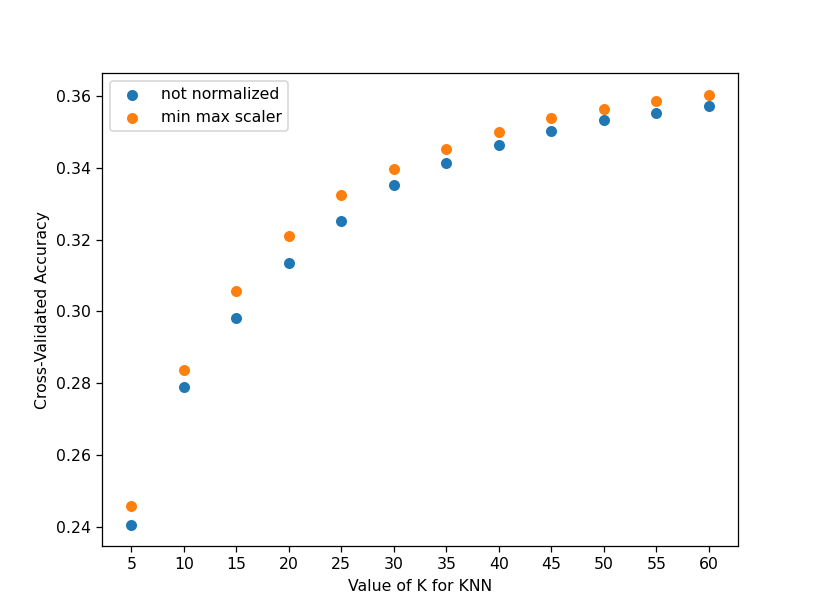

In [62]:
## Run model with and without normalized features with various k sizes
from sklearn.model_selection import cross_val_score

def knn_iteration(X, y):

    k_range = np.arange(5, 61, 5)
    k_scores = []
    
    for k in k_range:
        print("Running k-size {}".format(k))
        knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan', weights='distance')
        scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())

    mean = np.mean(np.asarray(k_scores))   
    sd = np.std(np.asarray(k_scores))     
        
    return_values = {"k_range":k_range, "k_scores":k_scores, "mean":mean, "sd":sd}    
    return return_values

non_normalized = knn_iteration(X_train, y_train)
minmax_scaled = knn_iteration(X_train_minmax, y_train)

## Create plot
plt.figure()

plt.xticks(non_normalized['k_range'])

plt.scatter(non_normalized['k_range'], non_normalized['k_scores'], label = "not normalized")
plt.scatter(minmax_scaled['k_range'], minmax_scaled['k_scores'], label = "min max scaler")

plt.legend()
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

plt.show()

### Use GridSearch to tune hyperparameters

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions


https://github.com/rohanjoseph93/Python-for-data-science/blob/master/Grid%20Search%20-%20Breast%20Cancer.ipynb

In [179]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def grid_search(X_train, y_train, X_test, y_test):

    y_train_flat = np.ravel(y_train)

    knn = KNeighborsClassifier()
    from sklearn.model_selection import GridSearchCV
    k_range = np.arange(5, 61, 5)

    param_grid = {'n_neighbors':k_range,
                  'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']}

    # defining parameter range
    grid = GridSearchCV(knn, param_grid,
                        cv=10, 
                        scoring='accuracy', return_train_score=False,verbose=1)

    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train_flat)
    y_pred = grid_search.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    print(grid_search.best_params_,"\n", classification_report(y_test, y_pred))
    
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_).plot(cmap=plt.cm.Blues)
    plt.yticks(size=10)
    plt.xticks(rotation = 45, size=10) 
    plt.show()
    
# grid_search(X_train, y_train, X_test, y_test)
# grid_search(X_train_minmax, y_train, X_test_minmax, y_test)

Plot knn decision boundary for bias / variance detection

documentation: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

### Using the classifier for Gerrit Cole

Turns out, MLB does not use a single LHP/RHP classifier for it's pitch classifications on its television broadcasts. This blog post on the MLB Technology Blog goes into great detail on the history of MLB pitch classifications. Turns out that one of the many ways they fine tune their models is that each *pitcher* has their own model that is trained specifically to that pitchers pitch attributes and classification systems (one pitchers sinker may be another's two seamer).

So let's run recreate some of our visuals and re-run our knn model, but this time only for Gerrit Cole. My expectation is that we should see much clearer clusters around pitch attributes compared to the lague average and also score a much higher accuracy rating on our classifier than our league-average model

In [95]:
path = r"C:\Users\pjrac\OneDrive\Documents\baseball_pitch_classifier"
player_names = pd.read_csv(r"C:\Users\pjrac\OneDrive\Documents\baseball_pitch_classifier\data\player_names.csv")
pitches = pd.read_csv(path+r'\\data\\pitches.csv')
pitch_type_dictionary = pd.read_csv(path+r'\\data\\pitch_type_dictionary.csv')
atbats = pd.read_csv(path+r"\\data\\atbats.csv")

pitches = pitches.merge(pitch_type_dictionary, on='pitch_type', how='left')
pitches = pitches.merge(atbats, on = "ab_id")

id first_name last_name
226   543037     Gerrit      Cole
441   595918       A.J.      Cole
1082  518566     Taylor      Cole

### Note i shouldn't have to dropna(), since i didn't with the big pitches dataset. Something is wrong

In [165]:
cole_id = player_names.loc[(player_names['first_name'] == "Gerrit")& (player_names['last_name'] == "Cole")]["id"].values[0]

cole = pitches.loc[pitches['pitcher_id'] == cole_id]
cole = cole.dropna()
## Create list of fields we're interested in
columns = ['break_length', 'spin_rate', 'start_speed', 'ax', 'spin_dir',
          'pitch_type', 'pitch_name', 'p_throws']

cole = cole[columns]

#Distribution of pitches
cole['pitch_type'].value_counts()

FF    5812
SL    2253
KC    1440
SI     815
CH     715
FT     626
CU      29
IN      13
PO       4
Name: pitch_type, dtype: int64

Only take his frequent pitches, as those cutters were probably misclassified sliders

In [166]:
cole_pitches = ['FF', 'SL', 'KC', 'SI', 'CH', 'FT']

cole = cole.loc[cole["pitch_type"].isin(cole_pitches)]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'metric': 'euclidean', 'n_neighbors': 35, 'weights': 'distance'} 
               precision    recall  f1-score   support

          CH       0.97      0.95      0.96        75
          FF       0.87      0.97      0.92       549
          FT       0.76      0.41      0.53        71
          KC       0.92      1.00      0.96       160
          SI       0.63      0.39      0.48        74
          SL       1.00      0.94      0.97       238

    accuracy                           0.90      1167
   macro avg       0.86      0.78      0.80      1167
weighted avg       0.89      0.90      0.89      1167



[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   19.9s finished


<IPython.core.display.Javascript object>


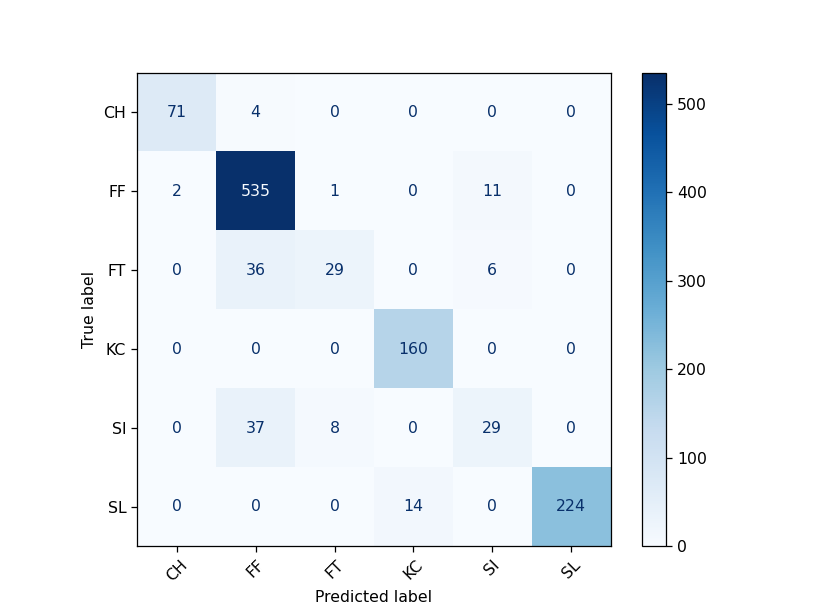

In [180]:
X2= cole.loc[:, (cole.columns != 'pitch_name') & (cole.columns != 'pitch_type') 
          & (cole.columns != 'p_throws')]

y2 = np.array(cole['pitch_type'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=0.90, random_state=0)

X_train_minmax2 = min_max_scale(X_train2)
X_test_minmax2 = min_max_scale(X_test2)

grid_search(X_train_minmax2, y_train2, X_test_minmax2, y_test2)

### bias/accuracy

In [18]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y)



tree = DecisionTreeClassifier(random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.062
Average bias: 0.022
Average variance: 0.040
